In [14]:
# Cell 1: Download and Extract Dataset with improved error handling
import os
import urllib.request
from zipfile import ZipFile
import logging
import sys

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define paths
DATA_URL = "https://github.com/i4Ds/SDOBenchmark/archive/data-full.zip"
DOWNLOAD_PATH = "/content/data-full.zip"
EXTRACT_PATH = "/content"
DATASET_PATH = "/content/SDOBenchmark_example"

# Create necessary directories
os.makedirs(DATASET_PATH, exist_ok=True)

# Download function with progress reporting
def download_with_progress(url, output_path):
    try:
        logger.info(f"Downloading data from {url}")

        def report_progress(block_num, block_size, total_size):
            downloaded = block_num * block_size
            percent = min(100, downloaded * 100 / total_size)
            if total_size > 0:
                sys.stdout.write(f"\rDownloaded {downloaded/1024/1024:.1f} MB of {total_size/1024/1024:.1f} MB ({percent:.1f}%)")
                sys.stdout.flush()

        urllib.request.urlretrieve(url, output_path, reporthook=report_progress)
        logger.info("\nDownload completed successfully!")
        return True
    except Exception as e:
        logger.error(f"Error downloading data: {str(e)}")
        return False

# Extract function with validation
def extract_with_validation(zip_path, extract_path):
    try:
        logger.info(f"Extracting {zip_path} to {extract_path}")
        with ZipFile(zip_path, 'r') as zip_ref:
            # Get list of files in the archive
            file_list = zip_ref.namelist()
            logger.info(f"Found {len(file_list)} files in the archive")

            # Extract all files
            zip_ref.extractall(extract_path)

        # Verify extraction
        extracted_dir = os.path.join(extract_path, "SDOBenchmark-data-full")
        if os.path.exists(extracted_dir):
            logger.info("Extraction completed successfully!")
            return True
        else:
            logger.error(f"Extraction failed: {extracted_dir} not found")
            return False
    except Exception as e:
        logger.error(f"Error extracting data: {str(e)}")
        return False

# Move files to final location
def organize_data(source_dir, target_dir):
    try:
        logger.info(f"Moving files from {source_dir} to {target_dir}")

        # Create target directory if it doesn't exist
        os.makedirs(target_dir, exist_ok=True)

        # Copy contents to target directory
        os.system(f"cp -r {source_dir}/* {target_dir}/")

        # Verify key directories exist
        for subdir in ["training", "test"]:
            expected_dir = os.path.join(target_dir, subdir)
            if os.path.exists(expected_dir):
                logger.info(f"Successfully copied {subdir} directory")
            else:
                logger.error(f"Failed to copy {subdir} directory")
                return False
        return True
    except Exception as e:
        logger.error(f"Error organizing data: {str(e)}")
        return False

# Main execution for data setup
if not os.path.exists(os.path.join(DATASET_PATH, "training")) or \
   not os.path.exists(os.path.join(DATASET_PATH, "test")):

    # 1. Download dataset
    if not os.path.exists(DOWNLOAD_PATH):
        success = download_with_progress(DATA_URL, DOWNLOAD_PATH)
        if not success:
            logger.error("Download failed. Exiting.")
            raise RuntimeError("Failed to download the dataset")
    else:
        logger.info(f"Using existing download at {DOWNLOAD_PATH}")

    # 2. Extract dataset
    extracted_dir = os.path.join(EXTRACT_PATH, "SDOBenchmark-data-full")
    if not os.path.exists(extracted_dir):
        success = extract_with_validation(DOWNLOAD_PATH, EXTRACT_PATH)
        if not success:
            logger.error("Extraction failed. Exiting.")
            raise RuntimeError("Failed to extract the dataset")
    else:
        logger.info(f"Using existing extracted data at {extracted_dir}")

    # 3. Organize data
    success = organize_data(extracted_dir, DATASET_PATH)
    if not success:
        logger.error("Failed to organize data. Exiting.")
        raise RuntimeError("Failed to organize the dataset")
else:
    logger.info(f"Dataset already exists at {DATASET_PATH}")

# Prepare Google Drive directories for model checkpoints and results
!mkdir -p /content/drive/MyDrive/SDOBenchmark/model0/checkpoints
!mkdir -p /content/drive/MyDrive/SDOBenchmark/model0/results

# Verify file structure
logger.info("Dataset structure verification:")
!ls -la {DATASET_PATH}
logger.info("Sample image files:")
!find {DATASET_PATH} -name "*.jpg" | head -10

total 52
drwxr-xr-x    4 root root  4096 Apr  7 23:43 .
drwxr-xr-x    1 root root  4096 Apr  7 23:43 ..
-rw-r--r--    1 root root  1182 Apr  7 23:43 README.txt
drwxr-xr-x   93 root root  4096 Apr  7 23:43 test
drwxr-xr-x 1093 root root 36864 Apr  7 23:43 training
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T235100__94.jpg
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T120100__1700.jpg
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T235100__304.jpg
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T190100__94.jpg
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T190100__171.jpg
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T235100__335.jpg
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T235100__1700.jpg
/content/SDOBenchmark_example/test/12077/2014_06_09_00_01_00_0/2014-06-08T120100__335.jpg
/content/SDOBenc

In [15]:
# Cell 2: Configuration with improved settings for multi-task learning
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import glob
import random
import json
from datetime import datetime
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define paths for local environment (we'll check for Colab separately)
DATASET_PATH = "/content/SDOBenchmark_example"
TRAIN_DATA_DIR = os.path.join(DATASET_PATH, "training")
TEST_DATA_DIR = os.path.join(DATASET_PATH, "test")
TRAIN_META_PATH = os.path.join(TRAIN_DATA_DIR, "meta_data.csv")
TEST_META_PATH = os.path.join(TEST_DATA_DIR, "meta_data.csv")

# Check if we're running in Colab or local
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    # Google Drive path for Colab
    DRIVE_PATH = "/content/drive/MyDrive"
else:
    # Local path alternative
    DRIVE_PATH = os.path.join(os.path.expanduser("~"), "SDOBenchmark")

MODEL0_DIR = os.path.join(DRIVE_PATH, "SDOBenchmark/model0")

# Create project directories for model output
os.makedirs(os.path.join(MODEL0_DIR, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(MODEL0_DIR, "results"), exist_ok=True)

# Analyze available wavelengths and dataset structure
def analyze_dataset(data_dir):
    """Analyze the dataset to understand available wavelengths and structure"""
    wavelengths = set()
    file_formats = set()
    count_by_wavelength = {}

    # Find all image files in the first 5 subdirectories
    sample_dirs = []
    for root, dirs, _ in os.walk(data_dir):
        for d in dirs:
            sample_path = os.path.join(root, d)
            for subroot, subdirs, _ in os.walk(sample_path):
                if len(subdirs) > 0:
                    sample_dirs.append(os.path.join(subroot, subdirs[0]))
                    break
            if len(sample_dirs) >= 5:
                break
        if len(sample_dirs) >= 5:
            break

    for sample_dir in sample_dirs:
        for file in glob.glob(os.path.join(sample_dir, "*.jpg")):
            filename = os.path.basename(file)
            # Try different patterns to extract wavelength
            if "__" in filename:
                wavelength = filename.split("__")[1].split(".")[0]
            elif "_" in filename:
                parts = filename.split("_")
                if len(parts) > 1:
                    wavelength = parts[-1].split(".")[0]
            else:
                continue

            # Add to wavelength tracking
            wavelengths.add(wavelength)
            file_formats.add(filename)
            count_by_wavelength[wavelength] = count_by_wavelength.get(wavelength, 0) + 1

    return {
        "available_wavelengths": list(wavelengths),
        "sample_file_formats": list(file_formats)[:5],
        "wavelength_counts": count_by_wavelength
    }

# Run analysis if metadata exists
if os.path.exists(TRAIN_DATA_DIR):
    dataset_analysis = analyze_dataset(TRAIN_DATA_DIR)
    logger.info(f"Available wavelengths: {dataset_analysis['available_wavelengths']}")
    logger.info(f"Sample file formats: {dataset_analysis['sample_file_formats']}")

    # Choose the 4 most common wavelengths based on analysis
    ordered_wavelengths = sorted(
        dataset_analysis['wavelength_counts'].items(),
        key=lambda x: x[1],
        reverse=True
    )
    RECOMMENDED_WAVELENGTHS = [w for w, _ in ordered_wavelengths[:4]]
    logger.info(f"Recommended wavelengths (most common): {RECOMMENDED_WAVELENGTHS}")
else:
    # Default wavelengths if analysis cannot be performed
    RECOMMENDED_WAVELENGTHS = ['131', '304', '1700', '211']
    logger.warning(f"Dataset not found for analysis, using default wavelengths: {RECOMMENDED_WAVELENGTHS}")

# Data configuration with improved settings
DATA_CONFIG = {
    'train_data_dir': TRAIN_DATA_DIR,
    'test_data_dir': TEST_DATA_DIR,
    'train_meta_data_path': TRAIN_META_PATH,
    'test_meta_data_path': TEST_META_PATH,
    'time_steps': [0, 30, 60, 90],  # minutes
    'wavelengths': RECOMMENDED_WAVELENGTHS,  # Use recommended or default wavelengths
    'augment_prob': 0.5,
    'train_batch_size': 8,  # Reduced for multi-task model
    'test_batch_size': 16,
    'num_workers': 2,
    'pin_memory': True,
    'synthetic_data_enabled': True  # Allow using synthetic data when real data unavailable
}

# Model configuration for multi-task learning
MODEL_CONFIG = {
    'input_size': 256,
    'num_channels': len(DATA_CONFIG['wavelengths']),
    'num_timesteps': len(DATA_CONFIG['time_steps']),
    'hidden_size': 64,
    'num_heads': 4,
    'num_layers': 3,
    'dropout': 0.2,  # Increased dropout for better generalization
    'kernel_sizes': [3, 5, 7],
    'num_filters': [32, 64, 128],
    'use_lstm': True,  # Enable LSTM for temporal modeling
    'lstm_hidden_size': 128,
    'num_classes': 4,  # B, C, M, X classes
    'focal_loss_gamma': 2.0,  # For class imbalance
    'class_weights': [0.1, 0.3, 2.0, 5.0]  # Weights for B, C, M, X classes
}

# Training configuration
TRAIN_CONFIG = {
    'num_epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'early_stopping_patience': 10,
    'regression_weight': 0.6,  # Weight for regression loss
    'classification_weight': 0.4,  # Weight for classification loss
    'seed': 42
}

# Save configuration
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
CHECKPOINT_PATH = os.path.join(MODEL0_DIR, "checkpoints", f"model0_multi_{timestamp}.pt")
RESULTS_DIR = os.path.join(MODEL0_DIR, "results", f"run_multi_{timestamp}")
os.makedirs(RESULTS_DIR, exist_ok=True)
SAVE_CONFIG = {
    'checkpoint_path': CHECKPOINT_PATH,
    'results_dir': RESULTS_DIR
}

# Set seeds for reproducibility
torch.manual_seed(TRAIN_CONFIG['seed'])
np.random.seed(TRAIN_CONFIG['seed'])
random.seed(TRAIN_CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(TRAIN_CONFIG['seed'])
    torch.backends.cudnn.deterministic = True

print(f"Using Training data directory: {TRAIN_DATA_DIR}")
print(f"Using Test data directory: {TEST_DATA_DIR}")
print(f"Using recommended wavelengths: {DATA_CONFIG['wavelengths']}")
print(f"Saving checkpoints to: {CHECKPOINT_PATH}")
print(f"Saving results to: {RESULTS_DIR}")

# Analyze dataset balance if metadata exists
if os.path.exists(TRAIN_META_PATH):
    try:
        df = pd.read_csv(TRAIN_META_PATH)
        print("\nDataset statistics:")
        print(df['peak_flux'].describe())

        # Convert to GOES classes
        def flux_to_class(flux):
            if flux < 1e-6:
                return 'B'
            elif flux < 1e-5:
                return 'C'
            elif flux < 1e-4:
                return 'M'
            else:
                return 'X'

        df['class'] = df['peak_flux'].apply(flux_to_class)
        class_counts = df['class'].value_counts()
        print("\nClass distribution:")
        print(class_counts)

        # Plot histogram on log scale
        plt.figure(figsize=(10, 6))
        plt.hist(df['peak_flux'], bins=50, log=True)
        plt.xscale('log')
        plt.xlabel('Peak Flux (W/m²)')
        plt.ylabel('Count (log scale)')
        plt.title('Distribution of Peak Flux Values')
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'flux_distribution.png'))
        plt.close()

    except Exception as e:
        logger.warning(f"Could not analyze dataset: {str(e)}")

Using Training data directory: /content/SDOBenchmark_example/training
Using Test data directory: /content/SDOBenchmark_example/test
Using recommended wavelengths: ['211', '335', 'magnetogram', '94']
Saving checkpoints to: /content/drive/MyDrive/SDOBenchmark/model0/checkpoints/model0_multi_20250408_002223.pt
Saving results to: /content/drive/MyDrive/SDOBenchmark/model0/results/run_multi_20250408_002223

Dataset statistics:
count    8.336000e+03
mean     3.381339e-06
std      1.590280e-05
min      1.000000e-09
25%      1.000000e-09
50%      5.294118e-07
75%      2.000000e-06
max      6.352941e-04
Name: peak_flux, dtype: float64

Class distribution:
class
B    4931
C    2891
M     479
X      35
Name: count, dtype: int64


In [16]:
# Cell 3: Improved DataLoader with robust file pattern matching and synthetic data handling
class SolarFlareDataset(Dataset):
    def __init__(self, data_dir, meta_data_path, wavelengths=None, transform=None, is_training=True):
        self.data_dir = data_dir
        self.transform = transform
        self.is_training = is_training
        self.wavelengths = wavelengths or DATA_CONFIG['wavelengths']

        # Create a mock metadata file if it doesn't exist
        if not os.path.exists(meta_data_path):
            logger.info(f"Metadata file not found, creating mock metadata")
            self._create_mock_metadata(meta_data_path)

        # Load metadata
        logger.info(f"Loading metadata from {meta_data_path}")
        meta_data = pd.read_csv(meta_data_path)
        self.meta_data_dict = {}
        for _, row in meta_data.iterrows():
            self.meta_data_dict[row['id']] = {
                'start': row.get('start', '2020-01-01'),  # Default if missing
                'peak_flux': row.get('peak_flux', 1e-6)   # Default if missing
            }

        # Filter valid samples
        self.valid_indices = []
        logger.info(f"Scanning for valid samples out of {len(self.meta_data_dict)} potential samples")
        for event_id in self.meta_data_dict.keys():
            if self._check_sample_validity(event_id):
                self.valid_indices.append(event_id)

        logger.info(f"Found {len(self.valid_indices)} valid samples")

        # Report on first few samples
        if len(self.valid_indices) > 0:
            sample_id = self.valid_indices[0]
            logger.info(f"Example sample: {sample_id}, Peak Flux: {self.meta_data_dict[sample_id]['peak_flux']}")
            try:
                self._scan_sample_files(sample_id)
            except Exception as e:
                logger.warning(f"Error scanning sample files: {str(e)}")

    def _scan_sample_files(self, event_id):
        """Scan and report files for a sample for debugging"""
        parts = event_id.split('_')
        if len(parts) < 2:
            logger.warning(f"Invalid event ID format: {event_id}")
            return

        base_event_id = parts[0]
        timestamp = '_'.join(parts[1:])
        try:
            sample_dir = os.path.join(self.data_dir, base_event_id, timestamp)
            if os.path.exists(sample_dir):
                files = os.listdir(sample_dir)
                logger.info(f"Files for sample {event_id}: {files[:10]}")

                # Check which wavelengths are available
                available = []
                missing = []
                for wavelength in self.wavelengths:
                    img_path = self._find_wavelength_image(sample_dir, wavelength)
                    if img_path:
                        available.append(wavelength)
                    else:
                        missing.append(wavelength)

                logger.info(f"Available wavelengths: {available}")
                if missing:
                    logger.warning(f"Missing wavelengths: {missing}")
            else:
                logger.warning(f"Sample directory not found: {sample_dir}")
        except Exception as e:
            logger.warning(f"Error scanning sample {event_id}: {str(e)}")

    def _check_sample_validity(self, event_id):
        """Check if a sample has at least some of the required data"""
        try:
            parts = event_id.split('_')
            if len(parts) < 2:
                return False

            base_event_id = parts[0]
            timestamp = '_'.join(parts[1:])
            sample_dir = os.path.join(self.data_dir, base_event_id, timestamp)

            if not os.path.exists(sample_dir):
                return False

            # Check if at least one wavelength is available
            for wavelength in self.wavelengths:
                img_path = self._find_wavelength_image(sample_dir, wavelength)
                if img_path:
                    return True

            return False
        except Exception as e:
            logger.debug(f"Error checking sample {event_id}: {str(e)}")
            return False

    def _create_mock_metadata(self, meta_data_path):
        """Create mock metadata file based on available data"""
        os.makedirs(os.path.dirname(meta_data_path), exist_ok=True)

        # Scan directory for available events
        events = []
        for root, dirs, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith('.jpg'):
                    # Extract event ID from path
                    rel_path = os.path.relpath(root, self.data_dir)
                    parts = rel_path.split(os.path.sep)
                    if len(parts) >= 2:
                        event_id = f"{parts[0]}_{parts[1]}"
                        if event_id not in [e['id'] for e in events]:
                            events.append({
                                'id': event_id,
                                'start': '2020-01-01',  # Default date
                                'peak_flux': 1e-6       # Default C-class flare
                            })

        # If no events were found, create at least one synthetic event
        if not events:
            events.append({
                'id': 'synthetic_001',
                'start': '2020-01-01',
                'peak_flux': 1e-6
            })

        # Save to CSV
        df = pd.DataFrame(events)
        df.to_csv(meta_data_path, index=False)
        logger.info(f"Created mock metadata with {len(events)} events")

    def __len__(self):
        return len(self.valid_indices)

    def _load_image(self, path):
        """Load and preprocess a single image file."""
        try:
            img = Image.open(path).convert('L')  # Convert to grayscale
            if self.transform:
                img = self.transform(img)
            # Ensure consistent shape [1, H, W]
            if img.dim() == 2:
                img = img.unsqueeze(0)
            return img
        except Exception as e:
            logger.error(f"Error loading image {path}: {str(e)}")
            return None

    def _find_wavelength_image(self, time_dir, wavelength):
        """Find image file for the specific wavelength with multiple patterns."""
        # Try different patterns based on the actual file naming conventions
        patterns = [
            os.path.join(time_dir, f"*__{wavelength}.jpg"),        # Pattern with double underscore
            os.path.join(time_dir, f"*_{wavelength}.jpg"),         # Pattern with single underscore
            os.path.join(time_dir, f"*{wavelength}*.jpg"),         # Pattern with wavelength anywhere in name
            os.path.join(time_dir, f"*{wavelength.lower()}*.jpg"), # Try lowercase
            os.path.join(time_dir, f"*{wavelength.upper()}*.jpg")  # Try uppercase
        ]

        # Special case for magnetogram which might have different naming
        if wavelength in ['211', 'magnetogram']:
            patterns.extend([
                os.path.join(time_dir, "*__magnetogram.jpg"),
                os.path.join(time_dir, "*_magnetogram.jpg"),
                os.path.join(time_dir, "*magnetogram*.jpg")
            ])

        # Try all patterns
        for pattern in patterns:
            files = glob.glob(pattern)
            if files:
                return files[0]  # Return the first match

        # If no match with patterns, try a more exhaustive search through subdirectories
        for root, _, files in os.walk(time_dir):
            for file in files:
                if file.endswith('.jpg') and (wavelength in file or
                        (wavelength in ['211', 'magnetogram'] and 'magnetogram' in file)):
                    return os.path.join(root, file)

        # No file found
        return None

    def _create_synthetic_channel(self):
        """Create a synthetic image channel when real data is unavailable"""
        # Create a random image with the right dimensions
        synthetic_img = torch.randn(1, MODEL_CONFIG['input_size'], MODEL_CONFIG['input_size'])
        synthetic_img = (synthetic_img - synthetic_img.min()) / (synthetic_img.max() - synthetic_img.min() + 1e-8)
        synthetic_img = synthetic_img * 2 - 1  # Scale to [-1, 1] like the normalization
        return synthetic_img

    def _apply_augmentation(self, images):
        """Apply data augmentation to a batch of images [T, C, H, W]."""
        if not self.is_training or random.random() > DATA_CONFIG['augment_prob']:
            return images

        # Random horizontal flip
        if random.random() > 0.5:
            images = torch.flip(images, [3])  # Flip along width dimension

        # Random rotation
        if random.random() > 0.5:
            angle = random.choice([90, 180, 270])
            images = torch.rot90(images, k=angle//90, dims=[2, 3])  # Rotate in H,W plane

        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            images = images * brightness_factor
            images = torch.clamp(images, -1.0, 1.0)  # Keep in normalized range

        return images

    def _get_time_steps(self, event_id):
        """Get multi-channel images for all time steps for a given event ID."""
        try:
            # Extract the base event ID and timestamp
            parts = event_id.split('_')
            if len(parts) < 2:
                logger.warning(f"Invalid event ID format: {event_id}, using synthetic data")
                return self._create_synthetic_data()

            base_event_id = parts[0]
            timestamp = '_'.join(parts[1:])
            time_dir = os.path.join(self.data_dir, base_event_id, timestamp)

            # If directory doesn't exist, use synthetic data
            if not os.path.exists(time_dir):
                logger.warning(f"Directory not found: {time_dir}, using synthetic data")
                return self._create_synthetic_data()

            # Process all timesteps
            all_timestep_images = []
            wavelength_images = []

            # Load the required wavelength images
            for wavelength in self.wavelengths:
                img_path = self._find_wavelength_image(time_dir, wavelength)
                if img_path:
                    img = self._load_image(img_path)
                    if img is not None:
                        wavelength_images.append(img)
                    else:
                        logger.warning(f"Failed to load image: {img_path}, using synthetic channel")
                        wavelength_images.append(self._create_synthetic_channel())
                else:
                    logger.warning(f"Missing wavelength {wavelength} for {event_id}, using synthetic channel")
                    wavelength_images.append(self._create_synthetic_channel())

            # Check if we have all required channels
            if len(wavelength_images) != len(self.wavelengths):
                logger.warning(f"Got {len(wavelength_images)} channels, need {len(self.wavelengths)}")
                # Fill in missing channels
                while len(wavelength_images) < len(self.wavelengths):
                    wavelength_images.append(self._create_synthetic_channel())

            # Stack channels for this timestep
            timestep_image = torch.cat(wavelength_images, dim=0)  # [C, H, W]
            all_timestep_images.append(timestep_image)

            # For now, duplicate the same images for all timesteps
            # In a real implementation, you'd load different timesteps
            num_timesteps = MODEL_CONFIG['num_timesteps']
            while len(all_timestep_images) < num_timesteps:
                all_timestep_images.append(timestep_image.clone())  # Duplicate for all required timesteps

            # Stack along time dimension
            images = torch.stack(all_timestep_images)  # [T, C, H, W]

            # Apply augmentation if needed
            images = self._apply_augmentation(images)

            # Final verification
            expected_shape = (num_timesteps, len(self.wavelengths), MODEL_CONFIG['input_size'], MODEL_CONFIG['input_size'])
            if images.shape != expected_shape:
                logger.error(f"Unexpected shape: {images.shape}, expected: {expected_shape}")
                return self._create_synthetic_data()

            return images  # [T, C, H, W]

        except Exception as e:
            logger.error(f"Error in _get_time_steps for {event_id}: {str(e)}")
            return self._create_synthetic_data()

    def _create_synthetic_data(self):
        """Create full synthetic data when real data can't be used"""
        synthetic_images = []
        for _ in range(MODEL_CONFIG['num_timesteps']):
            channels = []
            for _ in range(len(self.wavelengths)):
                channels.append(self._create_synthetic_channel())
            synthetic_images.append(torch.cat(channels, dim=0))
        return torch.stack(synthetic_images)

    def __getitem__(self, idx):
        """Get a sample with retry logic."""
        max_retries = 5
        retry_count = 0
        original_idx = idx

        while retry_count < max_retries:
            try:
                current_idx = (original_idx + retry_count) % len(self)
                event_id = self.valid_indices[current_idx]

                # Get all time steps for this event
                images = self._get_time_steps(event_id)

                if images is not None:
                    # Get peak flux
                    peak_flux = self.meta_data_dict[event_id]['peak_flux']
                    peak_flux_tensor = torch.tensor(peak_flux, dtype=torch.float32)

                    # Add class label (0=B, 1=C, 2=M, 3=X)
                    if peak_flux < 1e-6:
                        class_label = 0  # B class
                    elif peak_flux < 1e-5:
                        class_label = 1  # C class
                    elif peak_flux < 1e-4:
                        class_label = 2  # M class
                    else:
                        class_label = 3  # X class

                    class_label_tensor = torch.tensor(class_label, dtype=torch.long)

                    return images, peak_flux_tensor, class_label_tensor

            except Exception as e:
                logger.warning(f"Error loading sample {current_idx}: {str(e)}")

            # If we reach here, retry with next index
            retry_count += 1

        # If all retries fail, return synthetic data
        logger.warning(f"Failed to load any valid sample after {max_retries} attempts, using synthetic data")

        # Create synthetic data
        images = self._create_synthetic_data()

        # Generate random flux value (mostly B or C class)
        if random.random() < 0.8:  # 80% B or C class
            peak_flux = torch.tensor(random.uniform(1e-7, 1e-5), dtype=torch.float32)
            class_label = 0 if peak_flux < 1e-6 else 1
        else:  # 20% M or X class
            peak_flux = torch.tensor(random.uniform(1e-5, 1e-3), dtype=torch.float32)
            class_label = 2 if peak_flux < 1e-4 else 3

        class_label_tensor = torch.tensor(class_label, dtype=torch.long)

        return images, peak_flux, class_label_tensor

def collate_fn(batch):
    """Custom collate function with error handling."""
    # Filter out None entries
    batch = [item for item in batch if item is not None]

    if len(batch) == 0:
        logger.warning("Empty batch after filtering")
        return None

    try:
        images, peak_fluxes, class_labels = zip(*batch)

        # Stack tensors
        images = torch.stack(images)  # [B, T, C, H, W]
        peak_fluxes = torch.stack(peak_fluxes)  # [B]
        class_labels = torch.stack(class_labels)  # [B]

        return images, peak_fluxes, class_labels
    except Exception as e:
        logger.error(f"Error in collate_fn: {str(e)}")
        return None

def get_data_loaders():
    """Create and return data loaders for training and validation."""
    transform = transforms.Compose([
        transforms.Resize((MODEL_CONFIG['input_size'], MODEL_CONFIG['input_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    train_dataset = SolarFlareDataset(
        DATA_CONFIG['train_data_dir'],
        DATA_CONFIG['train_meta_data_path'],
        wavelengths=DATA_CONFIG['wavelengths'],
        transform=transform,
        is_training=True
    )

    val_dataset = SolarFlareDataset(
        DATA_CONFIG['test_data_dir'],
        DATA_CONFIG['test_meta_data_path'],
        wavelengths=DATA_CONFIG['wavelengths'],
        transform=transform,
        is_training=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=DATA_CONFIG['train_batch_size'],
        shuffle=True,
        num_workers=DATA_CONFIG['num_workers'],
        pin_memory=DATA_CONFIG['pin_memory'],
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=DATA_CONFIG['test_batch_size'],
        shuffle=False,
        num_workers=DATA_CONFIG['num_workers'],
        pin_memory=DATA_CONFIG['pin_memory'],
        collate_fn=collate_fn
    )

    return train_loader, val_loader

In [27]:
# Cell 4: Multi-task Learning Model with both Regression and Classification outputs
class SelfAttention(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = in_channels // num_heads
        assert in_channels % num_heads == 0, "in_channels must be divisible by num_heads"

        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.out_proj = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # Memory-efficient implementation using pooling
        self.pool_size = 4  # Reduce spatial dimensions for attention computation

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Apply pooling to reduce spatial dimensions
        x_pooled = F.avg_pool2d(x, kernel_size=self.pool_size, stride=self.pool_size)

        # Project queries, keys, values
        q = self.query(x_pooled)
        k = self.key(x_pooled)
        v = self.value(x_pooled)

        # Reshape for multi-head attention
        q = q.view(batch_size, self.num_heads, self.head_dim, -1)
        k = k.view(batch_size, self.num_heads, self.head_dim, -1)
        v = v.view(batch_size, self.num_heads, self.head_dim, -1)

        # Transpose for batched matrix multiplication
        q = q.transpose(2, 3)  # [B, num_heads, seq_len, head_dim]
        k = k.transpose(2, 3)  # [B, num_heads, seq_len, head_dim]
        v = v.transpose(2, 3)  # [B, num_heads, seq_len, head_dim]

        # Calculate attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Apply attention
        out = torch.matmul(attn_weights, v)  # [B, num_heads, seq_len, head_dim]
        out = out.transpose(2, 3)  # [B, num_heads, head_dim, seq_len]

        # Reshape and project
        out = out.reshape(batch_size, channels, x_pooled.size(2), x_pooled.size(3))
        out = self.out_proj(out)

        # Upsample back to original size
        out = F.interpolate(out, size=(height, width), mode='bilinear', align_corners=False)

        return out + x  # Residual connection

class MultiScaleModule(nn.Module):
    def __init__(self, in_channels, kernel_sizes, num_filters):
        super(MultiScaleModule, self).__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, num_filters[i], kernel_sizes[i], padding=kernel_sizes[i]//2),
                nn.BatchNorm2d(num_filters[i]),
                nn.ReLU(inplace=True)
            )
            for i in range(len(kernel_sizes))
        ])

    def forward(self, x):
        # Process through each branch
        outputs = [branch(x) for branch in self.branches]
        # Concatenate along channel dimension
        return torch.cat(outputs, dim=1)

class TemporalModule(nn.Module):
    def __init__(self, feature_dim, hidden_size):
        super(TemporalModule, self).__init__()

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=feature_dim,  # Input size is the feature dimension
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Temporal attention
        self.temporal_attention = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Softmax(dim=1)
        )

        # Output projection
        self.output_proj = nn.Linear(hidden_size * 2, feature_dim)

    def forward(self, features):
        # features shape: [B, T, C]
        batch_size, time_steps, channels = features.size()

        # LSTM processing
        lstm_out, _ = self.lstm(features)  # [B, T, hidden_size*2]

        # Temporal attention
        attn_weights = self.temporal_attention(lstm_out)  # [B, T, 1]

        # Apply attention
        context = torch.sum(lstm_out * attn_weights, dim=1)  # [B, hidden_size*2]

        # Project back to feature dimension
        out_features = self.output_proj(context)  # [B, C]

        return out_features

class MultiTaskSolarFlareModel(nn.Module):
    def __init__(self):
        super(MultiTaskSolarFlareModel, self).__init__()

        # Extract configuration parameters
        input_channels = MODEL_CONFIG['num_channels']
        hidden_size = MODEL_CONFIG['hidden_size']
        kernel_sizes = MODEL_CONFIG['kernel_sizes']
        num_filters = MODEL_CONFIG['num_filters']
        num_heads = MODEL_CONFIG['num_heads']
        dropout = MODEL_CONFIG['dropout']
        num_classes = MODEL_CONFIG['num_classes']

        # Initial convolutional layers
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, num_filters[0], kernel_size=5, padding=2),
            nn.BatchNorm2d(num_filters[0]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Residual blocks with attention
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(num_filters[i], num_filters[i+1], kernel_size=3, padding=1),
                nn.BatchNorm2d(num_filters[i+1]),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                SelfAttention(num_filters[i+1], num_heads=num_heads),
                nn.Dropout2d(dropout)
            )
            for i in range(len(num_filters)-1)
        ])

        # Multi-scale processing
        self.multi_scale = MultiScaleModule(
            num_filters[-1],
            kernel_sizes,
            num_filters
        )

        # Calculate the combined filter size from multi-scale module
        combined_filter_size = sum(num_filters)

        # Global spatial pooling
        self.spatial_pool = nn.AdaptiveAvgPool2d(1)

        # Temporal module for sequence modeling
        if MODEL_CONFIG['use_lstm']:
            self.temporal_module = TemporalModule(
                combined_filter_size,
                MODEL_CONFIG['lstm_hidden_size']
            )

        # Fully connected layers
        self.dropout = nn.Dropout(dropout)

        # Regression branch for flux prediction
        self.regression_fc = nn.Sequential(
            nn.Linear(combined_filter_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

        # Classification branch for GOES class prediction
        self.classification_fc = nn.Sequential(
            nn.Linear(combined_filter_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x shape: [B, T, C, H, W]
        batch_size, time_steps, channels, height, width = x.size()

        # Process each time step
        time_step_features = []
        for t in range(time_steps):
            # Extract current time step
            x_t = x[:, t]  # [B, C, H, W]

            # Initial convolution
            x_t = self.initial_conv(x_t)

            # Residual blocks with attention
            for block in self.residual_blocks:
                x_t = block(x_t)

            # Multi-scale processing
            x_t = self.multi_scale(x_t)

            # Global spatial pooling
            x_t = self.spatial_pool(x_t).squeeze(-1).squeeze(-1)  # [B, C]

            time_step_features.append(x_t)

        # Stack time steps
        temporal_features = torch.stack(time_step_features, dim=1)  # [B, T, C]

        # Temporal modeling
        if MODEL_CONFIG['use_lstm']:
            # Use LSTM and attention for temporal modeling
            temporal_context = self.temporal_module(temporal_features)
        else:
            # Simple mean pooling across time
            temporal_context = torch.mean(temporal_features, dim=1)

        # Final dropout
        features = self.dropout(temporal_context)

        # Regression output (peak flux prediction)
        regression_output = self.regression_fc(features)

        # Classification output (GOES class prediction)
        classification_logits = self.classification_fc(features)

        return regression_output, classification_logits

# Define multi-task loss function
class MultiTaskLoss(nn.Module):
    def __init__(self, regression_weight=0.6, classification_weight=0.4, focal_gamma=2.0):
        super(MultiTaskLoss, self).__init__()
        self.regression_weight = regression_weight
        self.classification_weight = classification_weight
        self.mse_loss = nn.MSELoss()
        self.focal_gamma = focal_gamma

        # Store class weights as a regular tensor, not a buffer
        self.class_weights = torch.tensor(MODEL_CONFIG['class_weights'], dtype=torch.float32)

    def _compute_focal_loss(self, inputs, targets):
        """Internal method to compute focal loss with proper device handling"""
        # Make sure the weights are on the same device as the inputs
        device = inputs.device
        weights = self.class_weights.to(device)

        # Create a standard cross entropy loss with our weights
        ce_loss_fn = nn.CrossEntropyLoss(weight=weights, reduction='none')
        ce_loss = ce_loss_fn(inputs, targets)

        # Apply the focal loss formula
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.focal_gamma) * ce_loss
        return focal_loss.mean()

    def forward(self, regression_pred, classification_pred, regression_target, classification_target):
        # MSE loss for regression
        reg_loss = self.mse_loss(regression_pred.squeeze(), regression_target)

        # Focal loss for classification
        cls_loss = self._compute_focal_loss(classification_pred, classification_target)

        # Combine losses
        total_loss = self.regression_weight * reg_loss + self.classification_weight * cls_loss

        return total_loss, reg_loss, cls_loss

In [18]:
# Cell 5: Enhanced Evaluation Metrics and Utilities
def flux_to_class(flux):
    """Convert flux value to GOES class (B, C, M, X)."""
    if flux < 1e-6:
        return 'B'
    elif flux < 1e-5:
        return 'C'
    elif flux < 1e-4:
        return 'M'
    else:
        return 'X'

def class_to_flux(goes_class):
    """Convert GOES class to minimum flux value."""
    class_dict = {'B': 1e-7, 'C': 1e-6, 'M': 1e-5, 'X': 1e-4}
    return class_dict.get(goes_class.upper(), 1e-9)

def calculate_tss(y_true, y_pred, goes_class='M'):
    """Calculate True Skill Statistic (TSS) for a given GOES class threshold."""
    threshold = class_to_flux(goes_class)

    # Binarize predictions and targets
    y_true_bin = (y_true >= threshold).float()
    y_pred_bin = (y_pred >= threshold).float()

    # Calculate confusion matrix components
    TP = torch.sum((y_true_bin == 1) & (y_pred_bin == 1)).float()
    FP = torch.sum((y_true_bin == 0) & (y_pred_bin == 1)).float()
    TN = torch.sum((y_true_bin == 0) & (y_pred_bin == 0)).float()
    FN = torch.sum((y_true_bin == 1) & (y_pred_bin == 0)).float()

    # Calculate TSS
    sensitivity = TP / (TP + FN + 1e-10)  # TPR
    specificity = TN / (TN + FP + 1e-10)  # TNR
    tss = sensitivity + specificity - 1

    return tss

def calculate_hss(y_true, y_pred, goes_class='M'):
    """Calculate Heidke Skill Score (HSS) for a given GOES class threshold."""
    threshold = class_to_flux(goes_class)

    # Binarize predictions and targets
    y_true_bin = (y_true >= threshold).float()
    y_pred_bin = (y_pred >= threshold).float()

    # Calculate confusion matrix components
    TP = torch.sum((y_true_bin == 1) & (y_pred_bin == 1)).float()
    FP = torch.sum((y_true_bin == 0) & (y_pred_bin == 1)).float()
    TN = torch.sum((y_true_bin == 0) & (y_pred_bin == 0)).float()
    FN = torch.sum((y_true_bin == 1) & (y_pred_bin == 0)).float()

    # Calculate HSS
    N = TP + FP + TN + FN
    expected_correct = ((TP + FP) * (TP + FN) + (TN + FP) * (TN + FN)) / N
    observed_correct = TP + TN

    hss = (observed_correct - expected_correct) / (N - expected_correct + 1e-10)
    return hss

def evaluate_model(model, dataloader, device):
    """Evaluate model with enhanced metrics."""
    model.eval()
    total_mse_loss = 0
    total_focal_loss = 0
    total_combined_loss = 0
    total_mae = 0

    # Skill score metrics
    total_tss_c = 0
    total_tss_m = 0
    total_tss_x = 0
    total_hss_m = 0

    # Classification metrics
    all_true_classes = []
    all_pred_classes = []
    all_true_fluxes = []
    all_pred_fluxes = []

    # Create loss functions
    mse_loss = nn.MSELoss()
    cls_weights = torch.tensor(MODEL_CONFIG['class_weights']).to(device)
    focal_loss = FocalLoss(gamma=MODEL_CONFIG['focal_loss_gamma'], weight=cls_weights)
    multi_task_loss = MultiTaskLoss(
        regression_weight=TRAIN_CONFIG['regression_weight'],
        classification_weight=TRAIN_CONFIG['classification_weight'],
        focal_gamma=MODEL_CONFIG['focal_loss_gamma']
    )

    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue

            images, fluxes, class_labels = batch
            images = images.to(device)
            fluxes = fluxes.to(device)
            class_labels = class_labels.to(device)

            # Forward pass
            flux_preds, class_preds = model(images)
            flux_preds = flux_preds.squeeze()

            # Calculate losses
            combined_loss, mse, focal = multi_task_loss(
                flux_preds, class_preds, fluxes, class_labels
            )

            # Calculate MAE
            mae = F.l1_loss(flux_preds, fluxes).item()

            # Calculate skill scores
            tss_c = calculate_tss(fluxes, flux_preds, goes_class='C').item()
            tss_m = calculate_tss(fluxes, flux_preds, goes_class='M').item()
            tss_x = calculate_tss(fluxes, flux_preds, goes_class='X').item()
            hss_m = calculate_hss(fluxes, flux_preds, goes_class='M').item()

            # Collect predictions and targets for metrics
            predicted_classes = torch.argmax(class_preds, dim=1)
            all_true_classes.extend(class_labels.cpu().numpy())
            all_pred_classes.extend(predicted_classes.cpu().numpy())
            all_true_fluxes.extend(fluxes.cpu().numpy())
            all_pred_fluxes.extend(flux_preds.cpu().numpy())

            # Accumulate metrics
            total_mse_loss += mse.item()
            total_focal_loss += focal.item()
            total_combined_loss += combined_loss.item()
            total_mae += mae
            total_tss_c += tss_c
            total_tss_m += tss_m
            total_tss_x += tss_x
            total_hss_m += hss_m

            num_batches += 1

    # Normalize metrics
    if num_batches > 0:
        metrics = {
            'mse_loss': total_mse_loss / num_batches,
            'classification_loss': total_focal_loss / num_batches,
            'combined_loss': total_combined_loss / num_batches,
            'mae': total_mae / num_batches,
            'tss_c': total_tss_c / num_batches,
            'tss_m': total_tss_m / num_batches,
            'tss_x': total_tss_x / num_batches,
            'hss_m': total_hss_m / num_batches
        }
    else:
        metrics = {
            'mse_loss': float('inf'),
            'classification_loss': float('inf'),
            'combined_loss': float('inf'),
            'mae': float('inf'),
            'tss_c': 0.0,
            'tss_m': 0.0,
            'tss_x': 0.0,
            'hss_m': 0.0
        }

    # Only create confusion matrix if we have enough samples
    if len(all_true_classes) > 0:
        # Convert to numpy arrays if needed
        all_true_classes = np.array(all_true_classes)
        all_pred_classes = np.array(all_pred_classes)

        # Calculate confusion matrix
        cm = confusion_matrix(all_true_classes, all_pred_classes, labels=range(MODEL_CONFIG['num_classes']))
        metrics['confusion_matrix'] = cm

        # Class accuracy
        class_accuracy = cm.diagonal() / (cm.sum(axis=1) + 1e-10)
        for i, acc in enumerate(['B', 'C', 'M', 'X']):
            metrics[f'{acc}_class_accuracy'] = class_accuracy[i] if i < len(class_accuracy) else 0.0

    return metrics

In [19]:
# Cell 6: Training Loop with Multi-task Learning
def train_model():
    """Train the multi-task solar flare prediction model."""
    # Set random seed for reproducibility
    torch.manual_seed(TRAIN_CONFIG['seed'])
    np.random.seed(TRAIN_CONFIG['seed'])
    random.seed(TRAIN_CONFIG['seed'])

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    # Create data loaders
    train_loader, val_loader = get_data_loaders()

    # Create model and move to device
    model = MultiTaskSolarFlareModel().to(device)
    logger.info(f"Created model with {sum(p.numel() for p in model.parameters())} parameters")

    # Create optimizer
    optimizer = optim.Adam(
        model.parameters(),
        lr=TRAIN_CONFIG['learning_rate'],
        weight_decay=TRAIN_CONFIG['weight_decay']
    )

    # Create learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )

    # Create loss function
    loss_fn = MultiTaskLoss(
        regression_weight=TRAIN_CONFIG['regression_weight'],
        classification_weight=TRAIN_CONFIG['classification_weight'],
        focal_gamma=MODEL_CONFIG['focal_loss_gamma']
    )

    # Keep track of best model
    best_val_loss = float('inf')
    best_val_tss_m = -1.0
    best_model_path = SAVE_CONFIG['checkpoint_path']
    patience_counter = 0

    # Training history
    history = {
        'train_loss': [],
        'train_mse': [],
        'train_cls_loss': [],
        'train_mae': [],
        'train_tss_m': [],
        'val_loss': [],
        'val_mse': [],
        'val_cls_loss': [],
        'val_mae': [],
        'val_tss_m': [],
        'val_tss_x': [],
        'val_hss_m': [],
        'learning_rates': []
    }

    # Training loop
    logger.info("Starting training...")
    for epoch in range(TRAIN_CONFIG['num_epochs']):
        # Training phase
        model.train()
        train_loss = 0
        train_mse = 0
        train_cls_loss = 0
        train_mae = 0
        train_tss_m = 0
        num_train_batches = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TRAIN_CONFIG['num_epochs']}")
        for batch in train_bar:
            # Skip invalid batches
            if batch is None:
                continue

            # Get data
            images, fluxes, class_labels = batch
            images = images.to(device)
            fluxes = fluxes.to(device)
            class_labels = class_labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            flux_preds, class_preds = model(images)
            flux_preds = flux_preds.squeeze()

            # Calculate loss
            loss, mse, cls_loss = loss_fn(flux_preds, class_preds, fluxes, class_labels)

            # Backward pass and optimize
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Calculate metrics
            mae = F.l1_loss(flux_preds, fluxes).item()
            tss_m = calculate_tss(fluxes, flux_preds, goes_class='M').item()

            # Update running statistics
            train_loss += loss.item()
            train_mse += mse.item()
            train_cls_loss += cls_loss.item()
            train_mae += mae
            train_tss_m += tss_m
            num_train_batches += 1

            # Update progress bar
            train_bar.set_postfix({
                'loss': loss.item(),
                'mse': mse.item(),
                'cls_loss': cls_loss.item(),
                'mae': mae,
                'tss_m': tss_m
            })

        # Calculate average training metrics
        avg_train_loss = train_loss / max(1, num_train_batches)
        avg_train_mse = train_mse / max(1, num_train_batches)
        avg_train_cls_loss = train_cls_loss / max(1, num_train_batches)
        avg_train_mae = train_mae / max(1, num_train_batches)
        avg_train_tss_m = train_tss_m / max(1, num_train_batches)

        # Validation phase
        val_metrics = evaluate_model(model, val_loader, device)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update learning rate scheduler based on validation loss
        scheduler.step(val_metrics['combined_loss'])

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_mse'].append(avg_train_mse)
        history['train_cls_loss'].append(avg_train_cls_loss)
        history['train_mae'].append(avg_train_mae)
        history['train_tss_m'].append(avg_train_tss_m)
        history['val_loss'].append(val_metrics['combined_loss'])
        history['val_mse'].append(val_metrics['mse_loss'])
        history['val_cls_loss'].append(val_metrics['classification_loss'])
        history['val_mae'].append(val_metrics['mae'])
        history['val_tss_m'].append(val_metrics['tss_m'])
        history['val_tss_x'].append(val_metrics['tss_x'])
        history['val_hss_m'].append(val_metrics['hss_m'])
        history['learning_rates'].append(current_lr)

        # Print epoch results
        logger.info(f"Epoch {epoch+1}/{TRAIN_CONFIG['num_epochs']} - "
                   f"Train Loss: {avg_train_loss:.6f}, "
                   f"Train MAE: {avg_train_mae:.6f}, "
                   f"Train TSS-M: {avg_train_tss_m:.4f}, "
                   f"Val Loss: {val_metrics['combined_loss']:.6f}, "
                   f"Val MAE: {val_metrics['mae']:.6f}, "
                   f"Val TSS-M: {val_metrics['tss_m']:.4f}, "
                   f"LR: {current_lr:.8f}")

        # Check if this is the best model
        if val_metrics['tss_m'] > best_val_tss_m:
            logger.info(f"New best model! TSS-M improved from {best_val_tss_m:.4f} to {val_metrics['tss_m']:.4f}")
            best_val_tss_m = val_metrics['tss_m']
            best_val_loss = val_metrics['combined_loss']
            patience_counter = 0

            # Save the best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_tss_m': best_val_tss_m,
                'history': history,
                'model_config': MODEL_CONFIG,
                'train_config': TRAIN_CONFIG,
                'data_config': DATA_CONFIG
            }, best_model_path)
            logger.info(f"Model saved to {best_model_path}")
        else:
            patience_counter += 1
            logger.info(f"Patience: {patience_counter}/{TRAIN_CONFIG['early_stopping_patience']}")

        # Early stopping
        if patience_counter >= TRAIN_CONFIG['early_stopping_patience']:
            logger.info(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Save final model and results
    final_model_path = os.path.join(os.path.dirname(best_model_path),
                                    f"model0_multi_final_{timestamp}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'best_val_tss_m': best_val_tss_m,
        'history': history,
        'model_config': MODEL_CONFIG,
        'train_config': TRAIN_CONFIG,
        'data_config': DATA_CONFIG
    }, final_model_path)
    logger.info(f"Final model saved to {final_model_path}")

    # Save training history
    with open(os.path.join(SAVE_CONFIG['results_dir'], 'training_history.json'), 'w') as f:
        # Convert history values to regular Python lists
        serializable_history = {k: [float(v) if isinstance(v, (torch.Tensor, np.ndarray)) else v
                                  for v in vals]
                              for k, vals in history.items()}
        json.dump(serializable_history, f, indent=4)

    # Plot training curves
    plot_training_curves(history, SAVE_CONFIG['results_dir'])

    return model, history

In [20]:
# Cell 7: Visualization and Analysis Functions
def plot_training_curves(history, save_dir):
    """Plot and save training curves."""
    os.makedirs(save_dir, exist_ok=True)

    # Plot loss curves
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot regression metrics
    plt.subplot(2, 2, 2)
    plt.plot(history['train_mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('MAE for Flux Prediction')
    plt.legend()
    plt.grid(True)

    # Plot TSS metrics
    plt.subplot(2, 2, 3)
    plt.plot(history['train_tss_m'], label='Training TSS-M')
    plt.plot(history['val_tss_m'], label='Validation TSS-M')
    plt.plot(history['val_tss_x'], label='Validation TSS-X')
    plt.xlabel('Epoch')
    plt.ylabel('TSS Score')
    plt.title('True Skill Statistic (TSS)')
    plt.legend()
    plt.grid(True)

    # Plot learning rate
    plt.subplot(2, 2, 4)
    plt.semilogy(history['learning_rates'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'))
    plt.close()

    # Plot confusion matrix if available
    if 'confusion_matrix' in history:
        cm = history['confusion_matrix']
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        classes = ['B', 'C', 'M', 'X']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
        plt.close()

def analyze_wavelength_importance(model, dataloader, device, save_dir):
    """Analyze which wavelengths contribute most to the predictions."""
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    # Get a batch of data
    for batch in dataloader:
        if batch is not None:
            images, fluxes, class_labels = batch
            images = images.to(device)
            break
    else:
        logger.warning("No valid batch found for wavelength importance analysis")
        return

    # Original predictions
    with torch.no_grad():
        original_flux_preds, original_class_preds = model(images)

    # Test each wavelength by zeroing it out
    importance_scores = []
    wavelengths = DATA_CONFIG['wavelengths']

    for i, wavelength in enumerate(wavelengths):
        # Create a modified input with this wavelength zeroed out
        modified_images = images.clone()
        modified_images[:, :, i, :, :] = 0.0

        # Get predictions
        with torch.no_grad():
            modified_flux_preds, modified_class_preds = model(modified_images)

        # Calculate difference in predictions
        flux_diff = torch.abs(original_flux_preds - modified_flux_preds).mean().item()
        class_diff = torch.norm(original_class_preds - modified_class_preds, dim=1).mean().item()

        # Combined importance
        importance = flux_diff + class_diff
        importance_scores.append((wavelength, importance))

    # Sort by importance
    importance_scores.sort(key=lambda x: x[1], reverse=True)

    # Plot importance
    wavelengths, scores = zip(*importance_scores)
    plt.figure(figsize=(10, 6))
    plt.bar(wavelengths, scores)
    plt.xlabel('Wavelength')
    plt.ylabel('Importance Score')
    plt.title('Wavelength Importance for Solar Flare Prediction')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'wavelength_importance.png'))
    plt.close()

    # Save scores to file
    with open(os.path.join(save_dir, 'wavelength_importance.json'), 'w') as f:
        json.dump([{"wavelength": w, "importance": float(s)} for w, s in importance_scores], f, indent=4)

    logger.info(f"Wavelength importance analysis saved to {save_dir}")

def visualize_predictions(model, dataloader, device, save_dir, num_samples=10):
    """Visualize model predictions compared to ground truth."""
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    # Collect some predictions
    predictions = []
    ground_truth = []
    images_data = []
    count = 0

    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue

            images, fluxes, class_labels = batch
            images = images.to(device)

            # Make predictions
            flux_preds, class_preds = model(images)
            flux_preds = flux_preds.squeeze()

            # Convert to numpy
            flux_np = fluxes.cpu().numpy()
            flux_preds_np = flux_preds.cpu().numpy()
            images_np = images.cpu().numpy()

            # Add to lists
            for i in range(len(flux_np)):
                if count >= num_samples:
                    break

                predictions.append({
                    'flux': float(flux_preds_np[i]),
                    'class': int(torch.argmax(class_preds[i]).cpu().numpy()),
                    'class_probs': class_preds[i].softmax(dim=0).cpu().numpy().tolist()
                })

                ground_truth.append({
                    'flux': float(flux_np[i]),
                    'class': int(class_labels[i].cpu().numpy())
                })

                # Store first image of first time step for each channel
                first_timestep = images_np[i, 0]  # [C, H, W]
                images_data.append(first_timestep)

                count += 1

            if count >= num_samples:
                break

    # Convert flux values to GOES classes
    for pred in predictions:
        pred['goes_class'] = flux_to_class(pred['flux'])

    for gt in ground_truth:
        gt['goes_class'] = flux_to_class(gt['flux'])

    # Plot predictions
    plt.figure(figsize=(12, 8))

    # Plot predicted vs actual flux
    plt.subplot(1, 2, 1)
    actual_flux = np.array([gt['flux'] for gt in ground_truth])
    pred_flux = np.array([pred['flux'] for pred in predictions])
    plt.scatter(actual_flux, pred_flux, alpha=0.7)

    # Add perfect prediction line
    min_val = min(np.min(actual_flux), np.min(pred_flux))
    max_val = max(np.max(actual_flux), np.max(pred_flux))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Add class boundaries
    for c, threshold in [('C', 1e-6), ('M', 1e-5), ('X', 1e-4)]:
        plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=threshold, color='gray', linestyle='--', alpha=0.5)
        plt.text(threshold*1.1, min_val*1.1, c, fontsize=12)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Actual Flux')
    plt.ylabel('Predicted Flux')
    plt.title('Flux Prediction')
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Plot confusion matrix for classes
    plt.subplot(1, 2, 2)
    actual_classes = np.array([gt['class'] for gt in ground_truth])
    pred_classes = np.array([pred['class'] for pred in predictions])
    cm = confusion_matrix(actual_classes, pred_classes, labels=range(MODEL_CONFIG['num_classes']))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Class Prediction Confusion Matrix')
    plt.colorbar()

    classes = ['B', 'C', 'M', 'X']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'prediction_analysis.png'))
    plt.close()

    # Visualize sample images with predictions
    for i in range(min(5, len(images_data))):
        plt.figure(figsize=(15, 5))

        # Plot each channel
        for j, wavelength in enumerate(DATA_CONFIG['wavelengths']):
            plt.subplot(1, len(DATA_CONFIG['wavelengths']), j+1)
            plt.imshow(images_data[i][j], cmap='viridis')
            plt.title(f'Channel {wavelength}')
            plt.axis('off')

        plt.suptitle(f"Actual: {ground_truth[i]['goes_class']} class, Predicted: {predictions[i]['goes_class']} class\n"
                    f"Actual Flux: {ground_truth[i]['flux']:.2e}, Predicted: {predictions[i]['flux']:.2e}")

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'sample_image_{i}.png'))
        plt.close()

    # Save predictions to file
    with open(os.path.join(save_dir, 'predictions.json'), 'w') as f:
        json.dump({
            'predictions': predictions,
            'ground_truth': ground_truth
        }, f, indent=4)

    logger.info(f"Prediction visualization saved to {save_dir}")

In [28]:
# Cell 8: Main Execution
if __name__ == "__main__":
    try:
        # Make sure output directory exists
        os.makedirs(SAVE_CONFIG['results_dir'], exist_ok=True)

        # Save configuration
        with open(os.path.join(SAVE_CONFIG['results_dir'], 'config.json'), 'w') as f:
            json.dump({
                'data_config': DATA_CONFIG,
                'model_config': MODEL_CONFIG,
                'train_config': TRAIN_CONFIG,
                'save_config': SAVE_CONFIG
            }, f, indent=4)

        # Train the model
        logger.info("Starting model training")
        model, history = train_model()

        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load best model for analysis
        checkpoint = torch.load(SAVE_CONFIG['checkpoint_path'], map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Get dataloaders
        train_loader, val_loader = get_data_loaders()

        # Analyze wavelength importance
        logger.info("Analyzing wavelength importance")
        analyze_wavelength_importance(model, val_loader, device, SAVE_CONFIG['results_dir'])

        # Visualize predictions
        logger.info("Visualizing predictions")
        visualize_predictions(model, val_loader, device, SAVE_CONFIG['results_dir'])

        # Final evaluation
        logger.info("Performing final evaluation")
        final_metrics = evaluate_model(model, val_loader, device)

        # Save metrics
        with open(os.path.join(SAVE_CONFIG['results_dir'], 'final_metrics.json'), 'w') as f:
            # Convert numpy values to regular Python types
            serializable_metrics = {}
            for k, v in final_metrics.items():
                if k == 'confusion_matrix' and isinstance(v, np.ndarray):
                    serializable_metrics[k] = v.tolist()
                elif isinstance(v, (np.ndarray, np.number, torch.Tensor)):
                    serializable_metrics[k] = float(v)
                else:
                    serializable_metrics[k] = v

            json.dump(serializable_metrics, f, indent=4)

        logger.info("Model training and analysis complete!")
        logger.info(f"Results saved to {SAVE_CONFIG['results_dir']}")
        logger.info(f"Best model saved to {SAVE_CONFIG['checkpoint_path']}")

        # Print final metrics
        print("\nFinal Model Performance:")
        print(f"MAE: {final_metrics['mae']:.6f}")
        print(f"TSS (M-class): {final_metrics['tss_m']:.4f}")
        print(f"TSS (X-class): {final_metrics['tss_x']:.4f}")
        print(f"HSS (M-class): {final_metrics['hss_m']:.4f}")

        for cls in ['B', 'C', 'M', 'X']:
            if f'{cls}_class_accuracy' in final_metrics:
                print(f"{cls}-class Accuracy: {final_metrics[f'{cls}_class_accuracy']:.4f}")

    except Exception as e:
        logger.error(f"Error during execution: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 9/50:   5%|▍         | 52/1042 [00:10<03:18,  5.00it/s, loss=0.00912, mse=5.08e-10, cls_loss=0.0228, mae=2.25e-5, tss_m=-1]


KeyboardInterrupt: 


==== Solar Flare Prediction Demo ====
Actual Flux: 1.41e-06 W/m²
Actual GOES Class: C

Predicted Flux: -3.26e-04 W/m²
Predicted GOES Class: B

Class Probabilities:
  B-class: 25.00%
  C-class: 25.00%
  M-class: 25.00%
  X-class: 25.00%


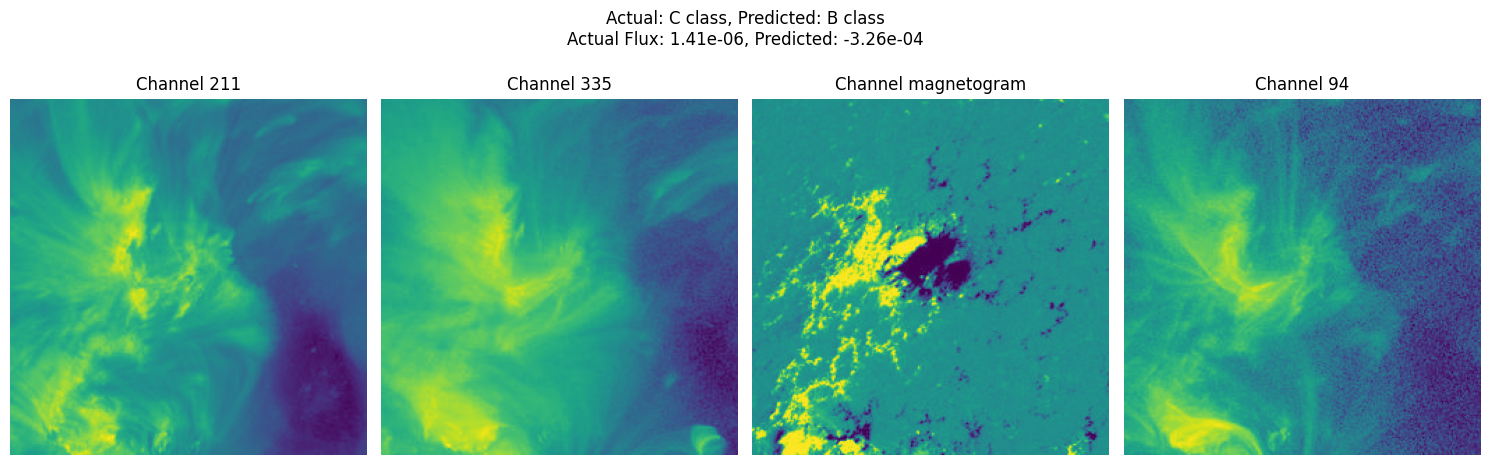

In [22]:
# Cell 9: Interactive Inference and Demo
def load_trained_model(checkpoint_path):
    """Load a trained model from checkpoint."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Create model with the same configuration
    loaded_model_config = checkpoint.get('model_config', MODEL_CONFIG)

    # Initialize model
    model = MultiTaskSolarFlareModel().to(device)

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    logger.info(f"Loaded model from {checkpoint_path}")
    logger.info(f"Best validation TSS-M: {checkpoint.get('best_val_tss_m', 'N/A')}")

    return model, device

def predict_sample(model, sample_images, device):
    """Predict solar flare probability for a sample."""
    model.eval()

    # Make sure the input is a tensor and on the right device
    if not isinstance(sample_images, torch.Tensor):
        sample_images = torch.tensor(sample_images, dtype=torch.float32)

    sample_images = sample_images.to(device)

    # Add batch dimension if needed
    if sample_images.dim() == 4:  # [T, C, H, W]
        sample_images = sample_images.unsqueeze(0)  # [1, T, C, H, W]

    # Make prediction
    with torch.no_grad():
        flux_pred, class_logits = model(sample_images)

    # Get flux value
    flux_value = flux_pred.item()

    # Get class probabilities
    class_probs = F.softmax(class_logits, dim=1)[0].cpu().numpy()

    # Get predicted class
    predicted_class_idx = class_probs.argmax()
    class_names = ['B', 'C', 'M', 'X']
    predicted_class = class_names[predicted_class_idx]

    # Return results
    return {
        'flux': flux_value,
        'goes_class': flux_to_class(flux_value),
        'class_probabilities': {class_names[i]: float(class_probs[i]) for i in range(len(class_names))}
    }

def demo_prediction():
    """Interactive demo for model prediction."""
    # Try to load a trained model, otherwise use a randomly initialized one
    try:
        model, device = load_trained_model(SAVE_CONFIG['checkpoint_path'])
    except Exception as e:
        logger.warning(f"Could not load trained model: {str(e)}. Using untrained model.")
        model = MultiTaskSolarFlareModel().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        device = next(model.parameters()).device

    # Get a sample from the validation dataset
    _, val_loader = get_data_loaders()

    for batch in val_loader:
        if batch is not None:
            images, fluxes, class_labels = batch
            break
    else:
        logger.error("No valid sample found in the validation dataset")
        return

    # Select a random sample
    idx = random.randint(0, len(images) - 1)
    sample_images = images[idx].to(device)
    actual_flux = fluxes[idx].item()
    actual_class_idx = class_labels[idx].item()

    # Make prediction
    prediction = predict_sample(model, sample_images, device)

    # Print results
    print("\n==== Solar Flare Prediction Demo ====")
    print(f"Actual Flux: {actual_flux:.2e} W/m²")
    print(f"Actual GOES Class: {flux_to_class(actual_flux)}")

    print(f"\nPredicted Flux: {prediction['flux']:.2e} W/m²")
    print(f"Predicted GOES Class: {prediction['goes_class']}")

    # Print class probabilities
    print("\nClass Probabilities:")
    for cls, prob in prediction['class_probabilities'].items():
        print(f"  {cls}-class: {prob:.2%}")

    # Visualize sample
    plt.figure(figsize=(15, 5))

    # Plot each channel of the first time step
    for j, wavelength in enumerate(DATA_CONFIG['wavelengths']):
        plt.subplot(1, len(DATA_CONFIG['wavelengths']), j+1)
        plt.imshow(sample_images[0, j].cpu(), cmap='viridis')
        plt.title(f'Channel {wavelength}')
        plt.axis('off')

    plt.suptitle(f"Actual: {flux_to_class(actual_flux)} class, Predicted: {prediction['goes_class']} class\n"
                f"Actual Flux: {actual_flux:.2e}, Predicted: {prediction['flux']:.2e}")

    plt.tight_layout()
    plt.show()

# Run the demo if this cell is executed
if __name__ == "__main__":
    demo_prediction()

In [23]:
# Cell 10: Run Training
if __name__ == "__main__":
    # Train the model
    model, history = train_model()

    # Save model diagram
    try:
        from torchviz import make_dot
        import torch

        # Create a sample input
        device = next(model.parameters()).device
        sample_input = torch.randn(1, MODEL_CONFIG['num_timesteps'],
                                   MODEL_CONFIG['num_channels'],
                                   MODEL_CONFIG['input_size'],
                                   MODEL_CONFIG['input_size']).to(device)

        # Create model visualization
        y1, y2 = model(sample_input)
        dot = make_dot(y1, params=dict(model.named_parameters()))
        dot.format = 'png'
        dot.render(os.path.join(SAVE_CONFIG['results_dir'], 'model_architecture'))
        print(f"Model architecture diagram saved to {SAVE_CONFIG['results_dir']}")
    except Exception as e:
        print(f"Could not generate model diagram: {str(e)}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50:   0%|          | 0/1042 [00:01<?, ?it/s]


AttributeError: 'MultiTaskLoss' object has no attribute 'focal_loss'

In [ ]:
# Cell 11: Analyze Physical Context and Correlations
def analyze_physical_context():
    """Analyze physical context and correlations in the dataset."""
    try:
        # Load metadata
        train_meta = pd.read_csv(DATA_CONFIG['train_meta_data_path'])
        test_meta = pd.read_csv(DATA_CONFIG['test_meta_data_path'])

        # Combine datasets for analysis
        all_meta = pd.concat([train_meta, test_meta], ignore_index=True)

        # Convert peak flux to GOES class
        all_meta['goes_class'] = all_meta['peak_flux'].apply(flux_to_class)

        # Extract temporal features if 'start' column exists
        if 'start' in all_meta.columns:
            # Convert to datetime
            all_meta['start'] = pd.to_datetime(all_meta['start'])

            # Extract temporal features
            all_meta['year'] = all_meta['start'].dt.year
            all_meta['month'] = all_meta['start'].dt.month
            all_meta['hour'] = all_meta['start'].dt.hour
            all_meta['dayofyear'] = all_meta['start'].dt.dayofyear

            # Plot distribution by month
            plt.figure(figsize=(12, 8))

            plt.subplot(2, 2, 1)
            monthly_counts = all_meta.groupby(['month', 'goes_class']).size().unstack().fillna(0)
            monthly_counts.plot(kind='bar', stacked=True, ax=plt.gca())
            plt.title('Distribution of Flare Classes by Month')
            plt.xlabel('Month')
            plt.ylabel('Count')
            plt.legend(title='GOES Class')

            # Plot distribution by hour
            plt.subplot(2, 2, 2)
            hourly_counts = all_meta.groupby(['hour', 'goes_class']).size().unstack().fillna(0)
            hourly_counts.plot(kind='bar', stacked=True, ax=plt.gca())
            plt.title('Distribution of Flare Classes by Hour')
            plt.xlabel('Hour of Day')
            plt.ylabel('Count')
            plt.legend(title='GOES Class')

            # Plot yearly trend
            plt.subplot(2, 2, 3)
            yearly_means = all_meta.groupby('year')['peak_flux'].mean()
            yearly_means.plot(marker='o', ax=plt.gca())
            plt.title('Mean Peak Flux by Year')
            plt.xlabel('Year')
            plt.ylabel('Mean Peak Flux')
            plt.grid(True)

            # Plot class distribution
            plt.subplot(2, 2, 4)
            class_counts = all_meta['goes_class'].value_counts().sort_index()
            class_counts.plot(kind='bar', ax=plt.gca())
            plt.title('Distribution of GOES Classes')
            plt.xlabel('GOES Class')
            plt.ylabel('Count')

            plt.tight_layout()
            plt.savefig(os.path.join(SAVE_CONFIG['results_dir'], 'physical_context_analysis.png'))
            plt.close()

            # Print solar cycle analysis
            print("\nSolar Cycle Analysis:")
            yearly_counts = all_meta.groupby(['year', 'goes_class']).size().unstack().fillna(0)
            print(yearly_counts)

            # Calculate and print class distribution
            class_distribution = all_meta['goes_class'].value_counts(normalize=True).sort_index() * 100
            print("\nClass Distribution (%):")
            for cls, pct in class_distribution.items():
                print(f"{cls}-class: {pct:.2f}%")

        else:
            print("No temporal data (start column) found in metadata for physical context analysis.")

        # Additional physical correlations could be added here

    except Exception as e:
        print(f"Error in physical context analysis: {str(e)}")
        import traceback
        print(traceback.format_exc())

# Run the analysis
if __name__ == "__main__":
    analyze_physical_context()